In [2]:
import pandas as pd


Read in the rps blast result dataframe

In [3]:
df = pd.read_csv("cdd_data_forindex.tsv", sep="\t")
df = df.drop(df.columns[0], axis=1)
df.head()


,contig_id,CDD,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,SRR
0,Contig_7830_48.5829:1.418,CDD:334282,26.263,99,53,4,31,279,204,298,0.000204,30.7,ERR1137115
1,Contig_29309_15.1119:1.3505,CDD:280594,29.032,93,63,2,1680,1408,51,142,0.000009,39.5,ERR1137115
2,Contig_19390_6.15113:1.331,CDD:280050,34.483,29,13,1,317,231,92,114,0.000421,28.9,ERR1137115
3,Contig_20647_88.0412:1.943,CDD:280594,44.000,25,14,0,746,820,89,113,0.000338,32.2,ERR1137115
4,Contig_18141_4.39216:1.224,CDD:281925,31.111,45,31,0,40,174,39,83,0.000690,26.9,ERR1137115


Plots of distribution of scores

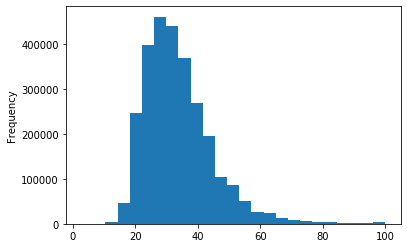

In [28]:
df['pident'].plot.hist(bins=25)

In [24]:
df.groupby("contig_id").count().sort_values(["CDD"], ascending=False)

,CDD,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,SRR
contig_id,,,,,,,,,,,,
NC_003663.2:1.224499,18767,18767,18767,18767,18767,18767,18767,18767,18767,18767,18767,18767
NC_006560.1:1.150715,12412,12412,12412,12412,12412,12412,12412,12412,12412,12412,12412,12412
NC_003310.1:1.196858,10080,10080,10080,10080,10080,10080,10080,10080,10080,10080,10080,10080
NC_001716.2:1.153080,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424
NC_001806.2:1.152222,3317,3317,3317,3317,3317,3317,3317,3317,3317,3317,3317,3317
...,...,...,...,...,...,...,...,...,...,...,...,...
Contig_25144_13.5382:1.1367,1,1,1,1,1,1,1,1,1,1,1,1
Contig_25144_11.21:1.239,1,1,1,1,1,1,1,1,1,1,1,1
Contig_25144_10.7232:1.244,1,1,1,1,1,1,1,1,1,1,1,1


Distribution of number of domain per contigs

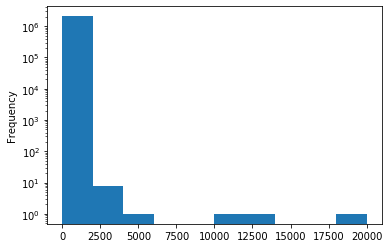

In [26]:
df.groupby("contig_id").count()['CDD'].plot.hist(range=(0,20000), log=True)

In [5]:
contig_df = df[df.contig_id.str.contains('^Contig_')]
contig_df.head()

,contig_id,CDD,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,SRR
0,Contig_7830_48.5829:1.418,CDD:334282,26.263,99,53,4,31,279,204,298,0.000204,30.7,ERR1137115
1,Contig_29309_15.1119:1.3505,CDD:280594,29.032,93,63,2,1680,1408,51,142,0.000009,39.5,ERR1137115
2,Contig_19390_6.15113:1.331,CDD:280050,34.483,29,13,1,317,231,92,114,0.000421,28.9,ERR1137115
3,Contig_20647_88.0412:1.943,CDD:280594,44.000,25,14,0,746,820,89,113,0.000338,32.2,ERR1137115
4,Contig_18141_4.39216:1.224,CDD:281925,31.111,45,31,0,40,174,39,83,0.000690,26.9,ERR1137115


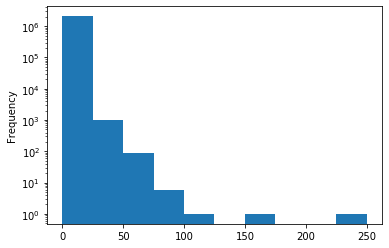

In [11]:
contig_df.groupby("contig_id").count().sort_values(["CDD"], ascending=False)['pident'].plot.hist(range=(0,250),log=True)